In [1]:
# Math Stuff
import numpy as np
import pandas as pd

# Proceesing librairies
from natsort import natsorted
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import imblearn

# Side Stuff
import joblib
import warnings
import colorama as col
import pyttsx3
engine = pyttsx3.init()
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

# Technical analysis
from finta import TA

# Plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

# Time Stuff
import time
import datetime as dt

print('Imblearn version ',imblearn.__version__)
print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Tensorflow version ',tf.__version__)
print('Joblib version ',joblib.__version__)

warnings.filterwarnings('ignore')


Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1


In [2]:
x = 'EUR/USD'
_period = 'm5'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2017-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'


In [3]:
def klines(df):
    _condition1 = df.Close >= df.Open
    df['Color'] = np.where(_condition1,1,-1)
    _condition2 = df.Color = 1
    df['UpperShadow'] = np.where(_condition2,(df.High-df.Close),(df.High-df.Open))
    df['LowerShadow'] = np.where(_condition2,(df.Open-df.Low),(df.Close-df.Low))
    df['Body'] = abs(df.Close-df.Open)
    return (df)

In [4]:
def undersample3(df):
    
    print('Avant Resampling :')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])
    print('Classe -1',df[df.Signal==-1].shape[0])

    # Class count
    count_class_0, count_class_1, count_class_2 = df_train.Signal.value_counts()
    # Divide by class
    df_class_0 = df[df.Signal== 0]
    df_class_1 = df[df.Signal != 0]

    df_class_0_under = df_class_0.sample(int((count_class_1+count_class_1)/1.5))
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    df = df.sort_index()
    print('Random under-sampling:')
    print(df.Signal.value_counts())

    # Classify and report the results
    print('\nAprès resample:')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])
    print('Classe -1',df[df.Signal==-1].shape[0])
    return df

def undersample2(df):
    
    print('Avant Resampling :')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])

    # Class count
    count_class_0, count_class_1 = df.Signal.value_counts()
    # Divide by class
    df_class_0 = df[df.Signal== 0]
    df_class_1 = df[df.Signal != 0]

    df_class_0_under = df_class_0.sample(int((count_class_1)))
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    df = df.sort_index()
    print('Random under-sampling:')
    print(df.Signal.value_counts())

    # Classify and report the results
    print('\nAprès resample:')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])
    return df

In [6]:
def split_df(df):
    """[Split the dtaframe in train/test/oos and reduce train and test to dataframe with signal!=0 only]

    Args:
        df ([pandas]): [the datframe to split already featured]
        _start ([date]): [beginning of the df]
        _mid ([date]): [stop of the train and beginning of the test]
        _stop ([date]): [stop of the test and beginning of the oos]
        _last ([date]): [end of the oos]
    """    
    df = df.dropna()
    df['Date'] = pd.to_datetime(df.index)
    
    df_train = df[(df.Date>=_start)&(df.Date<=_mid)]
    df_test = df[(df.Date>_mid)&(df.Date<=_stop)]
    df_oos = df[(df.Date>_stop)&(df.Date <= _last)]
    df_train = df_train.drop(['Date'],axis=1)
    df_test = df_test.drop(['Date'],axis=1)
    df_oos = df_oos.drop(['Date'],axis=1)
    return(df_train, df_test,df_oos)

%%time
_sl = 0.001
_target = 0.002
_nb_looser = 10000000000
TRACKER = []
_year_bottom = _start
_year_top = _stop

#scaler = Normalizer()
scaler = MinMaxScaler()
# scaler = StandardScaler()
df = joblib.load('BASES/EURUSD_m5')

def strategy(df):
    ##### CONDITIONS LONG
    _condition_1 = (df.slow_K5 < 20) & (df.slow_K5.shift(1) < df.slow_D5.shift(1)) & (df.slow_K5 > df.slow_D5)

    ##### CONDITIONS SHORT
    _condition_1_bar = (df.slow_K5 > 80) & (df.slow_K5.shift(1) > df.slow_D5.shift(1)) & (df.slow_K5 < df.slow_D5)

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    try:
        df = df.drop(['Symbol','Date','DateIndex','SB_Gamma'], axis=1)
    except:
        pass
    return(df.sort_index(axis=0)) 

def strategy5(df,_window=40):

    #df['RSI_2'] = TA.RSI(ohlc=df,int=2,str='Close')

    df['Window_High_Ask'] = df.HighAsk.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite SL Short
    df['Window_High_Bid'] = df.HighBid.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite Target Long
    df['Window_Low_Ask'] = df.LowAsk.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite Target Short
    df['Window_Low_Bid'] = df.LowBid.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite SL Long
    df['Window_sl_Short'] = df.CloseBid + (df.CloseBid * _sl) # Short pour SL
    df['Window_sl_Long'] = df.CloseAsk - (df.CloseAsk * _sl) # Long pour SL
    df['Window_tp_Short'] = df.CloseBid - (df.CloseBid * _target) # Short pour TP
    df['Window_tp_Long'] = df.CloseAsk + (df.CloseAsk * _target) # Long pour TP

    ##### CONDITIONS LONG
    _condition_1 = (df['Window_tp_Long'] <= df['Window_High_Bid']) & (df['Window_sl_Long'] <= df['Window_Low_Bid'])

    ##### CONDITIONS SHORT
    _condition_1_bar = (df['Window_tp_Short'] >= df['Window_Low_Ask']) & (df['Window_sl_Short'] >= df['Window_High_Ask'])

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    df = df.drop(['Symbol','Date','DateIndex','Window_High_Ask','Window_High_Bid','Window_Low_Ask','Window_Low_Bid','Window_sl_Short','Window_sl_Long','Window_tp_Short','Window_tp_Long'], axis=1)
    return(df.sort_index(axis=0))

df = klines(df)

df = strategy(df)

print()
print(col.Fore.CYAN,'###############################################################################################')
print(' #################################### TRAIN/TEST WITHOUT AI ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)


TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)


print()
print(col.Fore.BLUE,'###############################################################################################')
print(' #################################### DENOISING & ENHANCING ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)
while _nb_looser > 0 :
    
    df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)
    df['Valid'] = np.where(((df.Signal!=0)&(df.TRACKER==1)),1,0)
    df['Signal'] = np.where(((df.Valid==1)&(df.Signal==1)),1,np.where(((df.Valid==1)&(df.Signal==-1)),-1,0))
    ##### Purification of signal by denoising and enhancing
    TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)

print('Shape de features',df.shape)
df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)
df = strategy(df)
df = df[df.Signal!=0]
df['Signal'] = np.where(((df.Signal!=0)&(df.TRACKER==1)),1,0)

df_raw = df.copy()

df = undersample2(df)

df_train, df_test, df_oos = split_df(df)

df_train.sort_index(inplace=True)
for i in df.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid':
        df_train[i] = scaler.fit_transform(df_train[i].values.reshape(-1, 1))
        df_test[i] = scaler.fit_transform(df_test[i].values.reshape(-1, 1))
        df_oos[i] = scaler.fit_transform(df_oos[i].values.reshape(-1, 1))

df_train = df_train.dropna()
df_test = df_test.dropna()
df_oos = df_oos.dropna()

df_oos= df_oos.reindex(natsorted(df_oos.columns), axis=1)
df_test= df_test.reindex(natsorted(df_test.columns), axis=1)
df_train = df_train.reindex(natsorted(df_train.columns), axis=1)


joblib.dump(df,'BASES/df_EURUSD_m5')
joblib.dump(df_raw,'BASES/df_raw_EURUSD_m5')
joblib.dump(df_train,'BASES/df_train_EURUSD_m5')
joblib.dump(df_test,'BASES/df_test_EURUSD_m5')
joblib.dump(df_oos,'BASES/df_oos_EURUSD_m5')

df_train

## DEBUT BASE PREPAREE

In [147]:
import tensorflow
from tensorflow.keras.layers import Input, Dense, Activation,Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision, Metric
from keras.utils import to_categorical
# Disable eager execution
tf.compat.v1.disable_eager_execution()


In [191]:
%%time
df = joblib.load('BASES/df_EURUSD_m5')
df_raw = joblib.load('BASES/df_raw_EURUSD_m5')
df_train = joblib.load('BASES/df_train_EURUSD_m5')
df_test = joblib.load('BASES/df_test_EURUSD_m5')
df_oos = joblib.load('BASES/df_oos_EURUSD_m5')

X_train = df_train.drop(['Valid','Signal','TRACKER'],axis=1)
y_train = df_train[['Signal']]
X_test = df_test.drop(['Valid','Signal','TRACKER'],axis=1)
y_test = df_test[['Signal']]

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

#X_train = X_train.stack()
#X_test = X_test.stack()

X_train = X_train.values.reshape(-1,X_train.shape[1])
X_test = X_test.values.reshape(-1,X_test.shape[1])

y_train = y_train.reshape(-1,y_train.shape[1])
y_test = y_test.reshape(-1,y_test.shape[1])

#X_train = X_train.reshape(-1,X_train.shape[1]*X_train.shape[1])
#X_test = X_test.reshape(-1,X_test.shape[1]*X_test.shape[1])

CPU times: user 159 ms, sys: 156 ms, total: 315 ms
Wall time: 332 ms


In [192]:
df.shape,df_train.shape, df_test.shape,df_oos.shape

((5444, 66), (3242, 66), (903, 66), (919, 66))

<AxesSubplot:ylabel='Signal'>

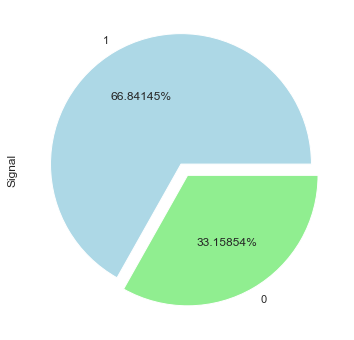

In [193]:
plt.figure(figsize=(24,6))
df_train.Signal.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange'], explode=(0.05, 0.05))

In [194]:
X_train.shape

(3242, 63)

## NAIVE BUILD ON

In [195]:

model  = tf.keras.models.Sequential()
_filters = df_train.shape[1]


model.add(tf.keras.layers.Conv1D(filters=63, kernel_size=1, padding='same', activation='relu',input_shape=(63,2)))

model.add(tf.keras.layers.Conv1D(filters=63, kernel_size=1, padding='same', activation='relu'))

model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='valid'))

model.add(tf.keras.layers.Conv1D(filters=63, kernel_size=1, activation='relu'))

model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation='relu',input_shape=(63,)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=256, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=64, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=2, activation='softmax'))


In [196]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 63, 63)            189       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 63, 63)            4032      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 62, 63)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 62, 63)            4032      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 61, 63)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 3843)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)             

In [197]:
%%time
#model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['mean_squared_error',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

CPU times: user 107 ms, sys: 1.83 ms, total: 109 ms
Wall time: 108 ms


In [198]:
X_train

array([[0.90932719, 0.94187093, 0.22897209, ..., 0.91366614, 0.14390563,
        0.1614809 ],
       [0.90932719, 0.94187093, 0.25617421, ..., 0.91956235, 0.15378025,
        0.17952819],
       [0.90932719, 0.94187093, 0.18701472, ..., 0.93779373, 0.15301279,
        0.17187714],
       ...,
       [0.13563748, 0.12648131, 0.17542691, ..., 0.14687488, 0.89957246,
        0.88942146],
       [0.13563748, 0.12648131, 0.13313178, ..., 0.15025472, 0.86656881,
        0.85494793],
       [0.13563748, 0.12648131, 0.07871056, ..., 0.15346187, 0.94462863,
        0.92395784]])

In [199]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [200]:
%%time
model.fit(X_train, y_train, epochs=5)

ValueError: Error when checking input: expected conv1d_13_input to have 3 dimensions, but got array with shape (3242, 63)

In [124]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1]*100,'%')
print("Test Precision:", score[2]*100,'%')
print("Test Recall:", score[3]*100,'%')

ValueError: Input arrays should have the same number of samples as target arrays. Found 926 input samples and 1852 target samples.

In [125]:
len(model.predict(X_test).reshape(-1,))

1852

In [126]:
yhat = pd.DataFrame()
yhat['Predict'] = model.predict(X_test).reshape(-1,)
_condition1 = yhat.Predict <= 0.5
_condition2 = yhat.Predict > 0.5
yhat['Predict'] = np.where(_condition1, 0, np.where(_condition2, 1, 999))
yhat.Predict.unique()

array([0, 1])

array([0., 1., 0., ..., 1., 0., 1.], dtype=float32)

In [127]:
tf.math.confusion_matrix(y_test.reshape(-1,), yhat.Predict, num_classes=None, weights=None, dtype=tf.dtypes.int32,name=None)

<tf.Tensor 'confusion_matrix_6/ScatterNd:0' shape=(2, 2) dtype=int32>

In [128]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

y_test = y_test.reshape(-1,)
yhat = yhat.Predict

accu = round(accuracy_score(y_test, yhat) * 100,2)
prec = round(precision_score(y_test, yhat,pos_label=1) * 100,2)
recall = round(recall_score(y_test, yhat) * 100,2)
f1 = round(f1_score(y_test, yhat) * 100,2)


#print('Signaux - Accuracy :' ,accu,'%')
print('Signaux - Precision :',prec,'%')
print('Signaux - Recall :', recall,'%')
print('Achat - F-measure: :' ,f1,'%')
print('\n')
print(classification_report(y_test, yhat, target_names=['Neg', 'Pos']))
conf_matrix = pd.DataFrame(columns=['Bonnes_Estimations','Mauvaises_Estimations'])
tt = confusion_matrix(y_test, yhat, labels=[1,0])    #_model.classes_)

conf_matrix.loc['vrais-réels'] = tt[0]
conf_matrix.loc['faux-réels'] = tt[1]

print(conf_matrix)
print()
print(col.Fore.BLUE,'Signaux pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
_tp = tt[0][0]
_fn = tt[0][1]
_prec = round((tt[0][0]/(tt[0][0]+tt[0][1]))*100,2)
_rec = round((tt[0][1]/(tt[0][0]+tt[0][1]))*100,2)

print('Vrais signaux trouvés    : ',tt[0][0])
print('Vrais signaux non trouvé :',tt[0][1])
print('Total des vrais signaux  :',tt[0][0]+tt[0][1])

if _prec > 69 and prec > 69 :
    print(col.Fore.GREEN,col.Style.RESET_ALL)
elif _prec < 51 or prec < 51 :
    print(col.Fore.RED,col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW)
print('Precision : ',_prec,'%')
if _rec > 69 and _rec > 69 :
    print(col.Fore.GREEN,col.Style.RESET_ALL)
elif _rec < 51 or _rec < 51 :
    print(col.Fore.RED,col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW)
print('Recall',_rec,'%',col.Style.RESET_ALL)

Signaux - Precision : 63.17 %
Signaux - Recall : 63.17 %
Achat - F-measure: : 63.17 %


              precision    recall  f1-score   support

         Neg       0.63      0.63      0.63       926
         Pos       0.63      0.63      0.63       926

    accuracy                           0.63      1852
   macro avg       0.63      0.63      0.63      1852
weighted avg       0.63      0.63      0.63      1852

            Bonnes_Estimations Mauvaises_Estimations
vrais-réels                585                   341
faux-réels                 341                   585

 Signaux pour  EUR/USD 
Vrais signaux trouvés    :  585
Vrais signaux non trouvé : 341
Total des vrais signaux  : 926

Precision :  63.17 %
 
Recall 36.83 % 


In [137]:
_, _, df_oos = split_df(df_raw)

df_train.sort_index(inplace=True)
for i in df.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid':
        df_oos[i] = scaler.fit_transform(df_oos[i].values.reshape(-1, 1))

df_oos = df_oos.dropna()

df_oos= df_oos.reindex(natsorted(df_oos.columns), axis=1)

X_oos = df_oos.drop(['Valid','Signal','TRACKER'],axis=1)

X_oos = X_oos.values.reshape(-1,X_oos.shape[1])

In [138]:
df_oos.shape

(11420, 66)

In [139]:
model.predict(X_oos).reshape(-1,).shape

(22840,)

In [140]:
%%time
df_oos['Valid'] = model.predict(X_oos)
_condition1 = df_oos.Valid <= 0.5
_condition2 = df_oos.Valid > 0.5
df_oos['Valid'] = np.where(_condition1, 0, np.where(_condition2, 1, 999))
df_oos.Valid.unique()

CPU times: user 201 ms, sys: 44.8 ms, total: 246 ms
Wall time: 155 ms


array([0, 1])

In [144]:
df_oos.Valid.value_counts()

0    7915
1    3505
Name: Valid, dtype: int64

In [145]:
%%time
_, _, df_oos_raw = split_df(df_raw)
df_oos_raw = strategy(df_oos_raw)
_condition1 = ((df_oos.Signal == 1) & (df_oos.Valid == 1))
_condition2 = ((df_oos.Signal == -1 )& (df_oos.Valid == 1))
df_oos_raw['Signal'] = np.where(_condition1,1,np.where(_condition2,-1,0))

CPU times: user 37.6 ms, sys: 5.86 ms, total: 43.4 ms
Wall time: 40.6 ms


In [146]:
_year_bottom = df_oos_raw.index[0]
_year_top = df_oos_raw.index[-1]
_verbose = 0
_,_ = bt(df_oos_raw,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)



_________________________________________________

__________________________________
     ___ Period 1 : =>  m5  ___
     ___ Period 2 : =>  H1  ___
__________________________________
Ca$h Ini : 200000
Date début: 2018-01-01 18:50:00
Date fin : 2021-04-28 23:55:00
Etat verbose : 0
Nombre Bougies Exit : 5555555555
Target : 0.002
Stop Loss : 0.001
Trigger Reengage : 0
Trigger Target : 1
Trigger Inverse : 0
Trigger StopLoss : 1
Trigger RSI : 0
Exposure : 2
_bt_report :  0
Verbose :  0
Trigger Spread : 0.025
Save :  0

_________________________________________________


Début des opérations horodatée à 2021-05-19 22:36:37.448311

 _trigger_rsi : 0 


Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1.0 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 11420/11420 [00:00<00:00, 19360.72it/s]
 For ticker  EUR/USD 
 
Total Profit & Loss : $  -38200.0 . En  579   transactions.
 
Winners Number : 176 
 
Loosers number : 403 
BT's execution time


TIK = ['AUD','NZD','GBP','JPY','CHF','CAD','SEK','NOK','ILS','MXN','USD','EUR']
RATE = [0.776,0.721,1.3912,1/105.91,1/0.892,1/1.2681,1/8.2884,1/8.4261,1/3.2385,1/20.1564,1,1.21]
df_ratefx = pd.DataFrame(index=TIK)
df_ratefx['rate'] = RATE

x = 'EUR/USD'
_period = 'm5'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2017-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'
_nb_bougie_exit = 5555555555
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.002
_sl = 0.001
_exposure = 2
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0



def bt(price,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_save=0,_bt_report=0,_trigger_rsi=_trigger_rsi):
    engine = pyttsx3.init()

    print(col.Fore.YELLOW)
    print('\n_________________________________________________\n')
    print('__________________________________')
    print('     ___ Period 1 : => ', _period,' ___')
    print('     ___ Period 2 : => ', _period2,' ___')
    print('__________________________________')
    print('Ca$h Ini :',_cash_ini)
    print('Date début:',_year_bottom)
    print('Date fin :',_year_top)
    print('Etat verbose :',_verbose)
    print('Nombre Bougies Exit :',_nb_bougie_exit)
    print('Target :',_target)
    print('Stop Loss :',_sl)
    print('Trigger Reengage :',_trigger_reengage)
    print('Trigger Target :',_trigger_target)
    print('Trigger Inverse :',_trigger_invers)
    print('Trigger StopLoss :',_trigger_sl)
    print('Trigger RSI :',_trigger_rsi)
    print('Exposure :',_exposure)
    print('_bt_report : ',_bt_report)
    print('Verbose : ',_verbose)
    print('Trigger Spread :',_trigger_spread)
    print('Save : ',_save)
    print('\n_________________________________________________\n')
    print(col.Style.RESET_ALL)

    engine.say("Backtesting in progress")
    engine.runAndWait()


    _t1 = dt.datetime.now()
    print('Début des opérations horodatée à',dt.datetime.now())
    print('\n _trigger_rsi :',_trigger_rsi,'\n')

    _total = 0
    _cash = _cash_ini
    _pnl = 0
    _tracker = 0

    DATE = []
    CONTRACT = []
    OPEN_POZ = []
    CLOSE_POZ = []
    RATE_OPEN_POZ = []
    RATE_CLOSE_POZ = []
    PNL_LAT = []
    PNL_REAL = []
    TOTAL_OPEN = []
    TOTAL_CLOSE = []
    PRICE_BUY = []
    PRICE_SELL = []
    DER_POZ = []
    TOTAL_PNL_LAT = []
    TOTAL_PNL_REAL = []
    EXPO_MAX = []
    TRACKER = []
    TRADE_DURATION = []
    PRICE_BUY = []
    PRICE_SELL = []
    EQUITY = []
    CASH = []
    
    df_resultats = pd.DataFrame(index=['Equity','Nbre Winners','Nbre winners long','Nbre winners short','Nbre Loosers','Nbre loosers long','Nbre loosers short','Max lenght of trade','Min lenght of trade',\
        'Average lenght of trade','Cumul pnl'])
    
    print('\nChargement de la nouvelle base\n\n')

    engine.say("קדימה")
    engine.runAndWait()

    print(col.Fore.MAGENTA,'Le rate du ticker',x,'est à ',_rate,col.Style.RESET_ALL)

    price = price[(price.index >= _year_bottom) & (price.index <= _year_top)]
    print('Bases chargées')

    print('TETEL process effectué')

    print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)

    time.sleep(0.2)
        
    price = price.dropna()

    _position = 0
    _equity = 0
    _nbtransactions = 0
    backtest_graph = pd.DataFrame()

    _winner = 0
    _looser = 0
    _longwinner = 0
    _longlooser = 0
    _shortwinner = 0
    _shortlooser = 0
    _index_entry = 0
    
    _average_duration = 0
    _total = 0

    

    _open_buy = 0
    _open_sell = 0

    for i in tqdm(range(0,len(price))):

        _size = _cash_ini / df_ratefx.loc[x[:3],'rate']

        ##### POSITIONS EN L'AIR 
        if i >= (len(price)-1) and (_position == 1 or _position == -1) :

            if _position == -1:
                _position = 99
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_sell
                    _longwinner+=_open_sell
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                
                TRADE_DURATION.append(i - _index_entry)
                
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_sell,'position closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            if _position == 1:

                _position = 99
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_buy,'positions closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
        
        # SI PAS DE POSITION
        if _position == 0:
            # BUY SIGNAL
            if  price.Signal[i] == 1: 
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 

            # SELL SIGNAL
            elif price.Signal[i] == -1: 
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            else :
                _pnl = 0
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                PNL_LAT.append(0)
                PNL_REAL.append(0)
                continue
        
        # SI POSITION LONG
        elif _position == 1:

            ### RE_ENGAGE BUY ON VALID SIGNAL
            if price.Signal[i] == 1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1\
                 and _open_buy < _exposure :
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
            
            ### CLOSE LONG ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] > 85:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            ### CLOSE LONG ON INVERSE SIGNAL
            if price.Signal[i] == -1 and _trigger_invers == 1:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            ### CLOSE LONG ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            # CLOSE LONG ON TARGET
            if (float(price.HighBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) >= _target and _trigger_target == 1:
                _position = 0
                _pnl = (price.HighBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            # CLOSE LONG ON STOP LOSS
            if (float(price. LowBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) <= - _sl and _trigger_sl == 1:
                _position = 0
                _pnl = (price.LowBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            else:

                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 
 
        # SI POSITION SHORT
        elif _position == -1:

            ### RE-ENGAGE SELL ON VALID SIGNAL
            if price.Signal[i] == -1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1 \
                and _open_sell < _exposure :
                
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            ### CLOSE SHORT ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] < 15:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON INVERSE SIGNAL
            if price.Signal[i] == 1 and _trigger_invers == 1:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TARGET
            if (float(price.LowAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) <= -_target and _trigger_target == 1:
                _position = 0
                _pnl = - (price.LowAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON STOP LOSS
            if (float(price.HighAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) > _sl and _trigger_sl == 1:
                _position = 0
                _pnl = - (price.HighAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            else:

                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _equity = _cash + _pnl

                EQUITY.append(_equity)
                CASH.append(_cash)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
        

    try:
        _average_duration = round(sum(TRADE_DURATION)/len(TRADE_DURATION),2)
        _max_duration = max(TRADE_DURATION)
        _min_duration = min([item for item in TRADE_DURATION if item !=0])

    except:
        print("(No Duration)") 
        _average_duration = 'NA'
        _max_duration = 0.00002
        _min_duration = 0.00001 
    print(col.Fore.BLUE,'For ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    if _total > 0:              
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.GREEN,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' )
    else:
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.RED,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' ) 
    print(col.Fore.GREEN,"\nWinners Number :",_winner,col.Style.RESET_ALL)
    print(col.Fore.RED,"\nLoosers number :",_looser,col.Style.RESET_ALL)

    backtest_graph['Equity'] = EQUITY

    df_resultats[x] = [(round(_equity,2)),(_winner),(_longwinner),(_shortwinner),(_looser),(_longlooser),(_shortlooser),(_max_duration),(_min_duration),(_average_duration),(_total)]

    DER_POZ.append(_pnl)

    engine.say("Finito caucau")
    engine.runAndWait()
    _t2 = dt.datetime.now()
    print("BT's execution time",str((_t2 - _t1)))
    df_historical = pd.DataFrame()
    df_historical = pd.DataFrame(index=DATE)
    df_historical['Contract'] = CONTRACT
    df_historical['Open_Poz'] = OPEN_POZ
    df_historical['Close_Pos'] = CLOSE_POZ
    df_historical['Rate_Open_Poz'] = RATE_OPEN_POZ 
    df_historical['Rate_Close_Poze'] = RATE_CLOSE_POZ
    df_historical['Pnl_Lat'] = TOTAL_PNL_LAT
    df_historical['Pnl_Real'] = TOTAL_PNL_REAL
    df_historical = df_historical.sort_index()
    _generated_cash = round(df_historical.Pnl_Real.sum(),2)
    _generated_cash_perc = round((_generated_cash / _cash_ini) * 100,2)
    print(col.Fore.YELLOW,x,col.Fore.BLUE,'results',col.Style.RESET_ALL)
    print(col.Fore.MAGENTA,'Tested Period',_year_bottom,' à',_year_top,col.Style.RESET_ALL)
    print(col.Fore.CYAN,'Total Number of trades',max([sum(TOTAL_OPEN),sum(TOTAL_CLOSE)]),col.Style.RESET_ALL)
    if _generated_cash <= 0:
        print('Started Cash :',_cash_ini)
        print('P&L in currency:',col.Fore.RED,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.RED,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    else:
        print('Started Cash :',_cash_ini)
        print('P&L  in currency:',col.Fore.GREEN,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.GREEN,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    print('Average trade duration',_average_duration)
    print('# Winners ',df_resultats.T['Nbre Winners'].sum())
    print('# Winners long ',df_resultats.T['Nbre winners long'].sum())
    print('# Winners short ',df_resultats.T['Nbre winners short'].sum())

    print('# Loosers ',df_resultats.T['Nbre Loosers'].sum())
    print('# Loosers  long',df_resultats.T['Nbre loosers long'].sum())
    print('# Loosers  short',df_resultats.T['Nbre loosers short'].sum())
    print('Cumulated gains',round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum(),2))
    print('Cumulated losses',round(df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2))
    print(col.Fore.BLUE,'PROFIT FACTOR : ',\
        abs(round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum()/df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2)),col.Style.RESET_ALL)
    try:
        print(col.Fore.CYAN,'Winners Ratio :',\
            round((df_resultats.T['Nbre Winners'].sum()*100)/(df_resultats.T['Nbre Loosers'].sum()+df_resultats.T['Nbre Winners'].sum()),2),\
                '%',col.Style.RESET_ALL)
    except:
        print(col.Fore.CYAN,'Winners Ratio  :None',col.Style.RESET_ALL)
    try:
        print('Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))),2))
        print('% Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))) * 100 / _cash_ini,2))
    except:
        print('No winner')
    try:
        print('Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))),2))
        print('% Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No looser')
    try:
        print('Average pnl',round(sum(PNL_REAL)/sum(TOTAL_OPEN),2))
        print('% Average pnl',round((sum(PNL_REAL)/len(set(PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No trade')
    
    print('Number of opened trades',sum(TOTAL_OPEN))
    print('Number of closed trades',sum(TOTAL_CLOSE))
    try:
        print('Max Exposure',max(EXPO_MAX),'x ',_size,'= ',max(EXPO_MAX)*_size,'$')
    except:
        print("Pas de trade => Pas d'exposure")
    candle_feedback = pd.DataFrame(index = price.index)
    candle_feedback['Symbol'] = x
    candle_feedback['Size'] = _size
    candle_feedback[_ticker] = EQUITY
    print('\n_bt_report :',_bt_report,'\n')
    
    if _bt_report == 1:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_oos.dag')

    elif _bt_report == 2:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_bt_bt.dag')
    
    elif _bt_report == 3:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_ai.dag')
    
    elif _bt_report == 4:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_custom.dag')
        
    return(TRACKER,df_resultats.T['Nbre Loosers'].sum())

,Close,CloseAsk,CloseBid,High,HighAsk,HighBid,Low,LowAsk,LowBid,Open,...,HighShift_weekly,LowShift_weekly,CloseShift_weekly,OpenShift_daily,HighShift_daily,LowShift_daily,CloseShift_daily,DateIndex,RSI_2_hourly,RSI_14_hourly
2010-01-04 00:00:00,1.431090,1.43119,1.43099,1.431640,1.43170,1.43158,1.430370,1.43046,1.43028,1.431640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-04 00:00:00,NaN,NaN
2010-01-04 00:05:00,1.430710,1.43079,1.43063,1.431130,1.43122,1.43104,1.429600,1.42969,1.42951,1.431090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-04 00:05:00,NaN,NaN
2010-01-04 00:10:00,1.429055,1.42915,1.42896,1.430840,1.43093,1.43075,1.429050,1.42914,1.42896,1.430710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-04 00:10:00,NaN,NaN
2010-01-04 00:15:00,1.430085,1.43019,1.42998,1.430270,1.43036,1.43018,1.428970,1.42906,1.42888,1.429055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-04 00:15:00,NaN,NaN
2010-01-04 00:20:00,1.431055,1.43115,1.43096,1.431210,1.43129,1.43113,1.429920,1.43001,1.42983,1.430085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-04 00:20:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-29 07:20:00,1.212215,1.21227,1.21216,1.212280,1.21234,1.21222,1.211795,1.21186,1.21173,1.211840,...,1.217008,1.200606,1.207615,1022.880118,-1.032470e+07,828.759349,-1.032504e+07,2021-04-29 07:20:00,19.999837,46.301406
2021-04-29 07:25:00,1.212050,1.21212,1.21198,1.212270,1.21232,1.21222,1.211955,1.21202,1.21189,1.212220,...,1.217008,1.200606,1.207615,1022.880118,-1.032470e+07,828.759349,-1.032504e+07,2021-04-29 07:25:00,19.999837,46.301406
2021-04-29 07:30:00,1.212015,1.21208,1.21195,1.212135,1.21219,1.21208,1.211820,1.21188,1.21176,1.212055,...,1.217008,1.200606,1.207615,1022.880118,-1.032470e+07,828.759349,-1.032504e+07,2021-04-29 07:30:00,19.999837,46.301406
2021-04-29 07:35:00,1.211890,1.21194,1.21184,1.212150,1.21221,1.21209,1.211610,1.21167,1.21155,1.212020,...,1.217008,1.200606,1.207615,1022.880118,-1.032470e+07,828.759349,-1.032504e+07,2021-04-29 07:35:00,19.999837,46.301406


In [26]:
df_train,df_test,df_oos  = split_df(df)

In [31]:
scaler = MinMaxScaler()
for i in df.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid' and i!= 'TRACKER':
        df_train[i] = scaler.fit_transform(df_train[i].values.reshape(-1, 1))
        df_test[i] = scaler.fit_transform(df_test[i].values.reshape(-1, 1))
        df_oos[i] = scaler.fit_transform(df_oos[i].values.reshape(-1, 1))

In [33]:
df_train

,Close,CloseAsk,CloseBid,High,HighAsk,HighBid,Low,LowAsk,LowBid,Open,...,CloseShift_daily,RSI_2_hourly,RSI_14_hourly,Color,UpperShadow,LowerShadow,Body,Signal,TRACKER,Valid
2011-06-20 08:40:00,0.912394,0.912346,0.912443,0.913421,0.913400,0.913441,0.912359,0.912360,0.912358,0.913666,...,0.945965,0.019805,0.404455,1,0.120063,0.254649,0.188729,1,1,1
2011-06-20 09:45:00,0.918155,0.918156,0.918154,0.919241,0.919233,0.919250,0.917934,0.917910,0.917958,0.919562,...,0.945965,0.716857,0.475031,1,0.124013,0.291845,0.204456,1,1,1
2011-06-20 17:10:00,0.936663,0.936652,0.936675,0.937519,0.937472,0.937565,0.936607,0.936583,0.936630,0.937794,...,0.945965,0.431129,0.660635,1,0.109795,0.240343,0.179554,1,1,1
2011-06-20 17:35:00,0.939606,0.939594,0.939617,0.940398,0.940364,0.940432,0.939912,0.939913,0.939911,0.940063,...,0.945965,0.431129,0.660635,1,0.105845,0.120172,0.108781,0,0,0
2011-06-21 05:50:00,0.948396,0.948372,0.948420,0.947603,0.947531,0.947674,0.947855,0.947880,0.947829,0.947489,...,0.959710,0.610455,0.675359,1,0.004739,0.060086,0.034076,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-29 01:25:00,0.133449,0.133447,0.133450,0.133255,0.133261,0.133249,0.135667,0.135665,0.135668,0.134910,...,0.156772,0.212175,0.533017,1,0.020537,0.028612,0.020970,1,1,1
2016-06-29 03:05:00,0.137158,0.137156,0.137159,0.137444,0.137487,0.137402,0.139404,0.139414,0.139393,0.138647,...,0.156772,0.614106,0.546242,1,0.051343,0.028612,0.024902,0,0,0
2016-06-29 05:55:00,0.134759,0.134782,0.134736,0.134998,0.134991,0.135004,0.136863,0.136874,0.136852,0.136230,...,0.156772,0.685211,0.555918,1,0.048183,0.042918,0.022280,0,0,0
2016-06-29 07:30:00,0.144328,0.144327,0.144330,0.145329,0.145322,0.145336,0.145842,0.145828,0.145856,0.146875,...,0.156772,0.704395,0.564556,1,0.097156,0.236052,0.138925,1,1,1


In [ ]:
_train